In [253]:
import os
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import signal

In [224]:
class DogOneData(Dataset):
    def _getfiles(self):
        files = sorted(os.listdir(self.root_dir))
        ffiles = list(filter(lambda f: 'test' not in f, files))
        return ffiles
    
    def _map_chnl_name_to_num(self, channels):
        chnls = [int((channel_name.item().split('_')[-1])[1:]) for channel_name in channels]
        return np.array(chnls, dtype=np.uint8)
    
    def __init__(self, root_dir, transform=None):
        subject_name = root_dir.split('/')
        self.root_dir = root_dir + '/' + subject_name[-1]
        self.transform = transform
    
    def __len__(self):
        files = self._getfiles()
        return len(files)
    
    def __getitem__(self, idx):
        files = self._getfiles()
        segment_path = os.path.join(self.root_dir, files[idx])
        mat = loadmat(segment_path)
        epoch_name = list(mat.keys())[-1]
        epoch = mat[epoch_name]
        data = epoch['data'][0][0]
        data_length_sec = torch.as_tensor(np.array(epoch['data_length_sec'][0][0][0][0], dtype=np.int16))        
        sampling_frequency = epoch['sampling_frequency'][0][0][0][0]
        channels = epoch['channels'][0][0][0]
        channels = self._map_chnl_name_to_num(channels)
        sequence = epoch['sequence'][0][0][0][0]
        if self.transform:
            data = self.transform(data)
        return data, data_length_sec, sampling_frequency, channels, sequence

In [225]:
training_data = DogOneData(
    root_dir='/Volumes/My Passport/AI_Research/data/Dog_1'
)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)

In [226]:
data, data_length_sec, sampling_frequency, channels, sequence = next(iter(train_dataloader))
print('Done.')

Done.


In [248]:
e = 15 # choose electrode (between 0-15)
N = data[e,:].shape[0]
t = np.arange(0, N) / sampling_frequency

Text(0, 0.5, 'Amplitude, $\\mu$V')

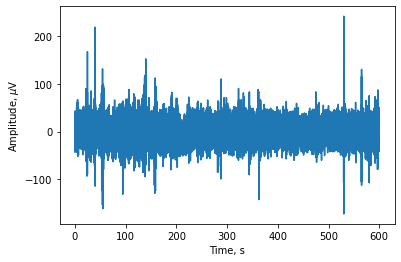

In [252]:
fig, ax = plt.subplots()
ax.plot(t, data[e,:])
ax.set_xlabel('Time, s')
ax.set_ylabel('Amplitude, $\mu$V')

In [255]:
timewin = 500 # in ms
# convert ms to idx
M = np.round(timewin/(1000/sampling_frequency)) # Nyquist frequency
# create Hann taper function
hann_win = signal.windows.hann(M-1)
# detrend data 
# this is done to attenuate super-low frequency artifacts in FFT
# from sampled data.
d = signal.detrend(x)

200.0